# Description - To run within SCC
# Creates results using Dense Model
# Currently, the file is created targeting the model saved in the path below
# restricted/projectnb/movelab/bcha/IMUforKnee/trainedModel/Dense_1st_torch/IWALQQ_AE_4th/

In [4]:
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import os
from os.path import join
from pickle import load
import pandas as pd
from natsort import natsorted
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Add the path to access helper modules (Windows path)
import sys
sys.path.append(r'R:\KumarLab3\PROJECTS\wesens\Data\Analysis\smith_dl\IMU Deep Learning\IMUforKnee\estimation\sensorwise')

# Import custom libraries
from dir_CBD import *
from plot_CBD import *
from scaler_CBD import *


In [6]:
motherDir = 'DenseModel'
######### Configuration Section ########
exp_name = 'date_Dense_1st_torch'  # Experiment name or today's date
modelVersion = 'Dense_1st_torch'
nameDataset = 'IWALQQ_1st_correction'  # Updated to match training script
dataType = 'angle'  # Updated to match training script (was 'moBWHT')

# Model location - Updated to match training script output structure
SaveDir = r"R:\KumarLab3\PROJECTS\wesens\Data\Analysis\smith_dl\IMU Deep Learning\Training_results\Dense_1st_Torch_Angle\models"
MODEL_DIR = join(SaveDir, modelVersion, nameDataset)

# Data location - Updated to match training script data path
dataDir = r"R:\KumarLab3\PROJECTS\wesens\Data\Analysis\smith_dl\IMU Deep Learning\Data\allnew_20220325_raw_byDeepak_csv\INC_ByStep\INC_ByZero\Included_checked\SAVE_dataSet"
DATA_DIR = join(dataDir, nameDataset)

# Fixed values
SEQ_LEN = 101
NUM_FEATURES = 42

# AI training settings
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:

# Angle prediction model
for numFold in range(0, 5):
    # Load model
    dir_savedTrainedModel = join(MODEL_DIR, f"{dataType}_{numFold}_fold.pt")
    my_model = torch.jit.load(dir_savedTrainedModel,map_location='cpu')
    my_model.eval()
    # Load data
    load_test = np.load(join(DATA_DIR, f"{numFold}_fold_final_test.npz"))
    load_scaler4Y = load(
        open(join(DATA_DIR, f"{numFold}_fold_scaler4Y_{dataType}.pkl"), "rb")
    )
    
    # Debug: Check what keys are available
    print(f"Available keys in fold {numFold}:", list(load_test.keys()))
    
    # Iterate through individual data for each fold
    for dataIndex in range(load_test["final_X_test"].shape[0]):
        # Prepare input and ground truth data
        X_test = np.squeeze(load_test["final_X_test"][dataIndex])
        X_test = X_test[None, :]  # Add batch dimension
        # X_dg = np.squeeze(load_test["final_DG_test"][dataIndex])  # Remove this line
        Y_true = load_test[f"final_Y_{dataType}_test"][dataIndex]
        # Inference
        Y_pred = my_model(
            torch.from_numpy(X_test).type(torch.FloatTensor))
        Y_pred = Y_pred.cpu().detach().numpy()
        Y_pred = np.reshape(Y_pred, [3, -1])
        Y_pred = np.transpose(Y_pred)
        # Rescale data back to original size
        Y_true_pick_afterscaler = (Y_true - load_scaler4Y.min_) / load_scaler4Y.scale_
        Y_pred_pick_afterscaler = (Y_pred - load_scaler4Y.min_) / load_scaler4Y.scale_
        
        df_true = pd.DataFrame(Y_true_pick_afterscaler, columns=['X_True','Y_True','Z_True'])
        df_pred = pd.DataFrame(Y_pred_pick_afterscaler, columns=['X_Pred','Y_Pred','Z_Pred'])
        df_save =  pd.concat([df_true, df_pred], axis=1)
        dfSaveDir = join(motherDir,modelVersion,nameDataset,dataType,f"{numFold}_fold")
        ensure_dir(dfSaveDir)
        df_save.to_excel(join(dfSaveDir,f"{dataIndex}.xlsx"))
    #     break  # For test data loop break
    # break  # For fold loop break


Available keys in fold 0: ['final_X_test', 'final_Y_angle_test', 'final_Y_moBWHT_test']
Available keys in fold 1: ['final_X_test', 'final_Y_angle_test', 'final_Y_moBWHT_test']
Available keys in fold 2: ['final_X_test', 'final_Y_angle_test', 'final_Y_moBWHT_test']
Available keys in fold 3: ['final_X_test', 'final_Y_angle_test', 'final_Y_moBWHT_test']
Available keys in fold 4: ['final_X_test', 'final_Y_angle_test', 'final_Y_moBWHT_test']


# Summary of total results and PDF plotting

In [10]:
# import 필요한 라이브러리
import os
from os.path import join
from natsort import natsorted
from pathlib import Path
import shutil
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import plot_CBD

In [11]:
# Main folder name to contain the results
targetDir = join(motherDir,modelVersion,nameDataset,dataType)
for axe in ["X","Y","Z"]:
   print("Axe : ", axe)
   globals()[f"true_{axe}"] = np.array([])
   globals()[f"pred_{axe}"] = np.array([])
   for fold in ["0_fold","1_fold","2_fold","3_fold","4_fold",]:
       print(f"now fold : ", fold)
       list_results = natsorted([_ for _ in os.listdir(join(targetDir,fold)) if _.endswith(".xlsx")])
       for result in list_results:
           singleResult = pd.read_excel(join(targetDir,fold,result))
           true = np.expand_dims(singleResult[f"{axe}_True"].to_numpy(), axis=0)
           pred = np.expand_dims(singleResult[f"{axe}_Pred"].to_numpy(), axis=0)
           if len(globals()[f"true_{axe}"]) ==0:
               globals()[f"true_{axe}"] = true
               globals()[f"pred_{axe}"] = pred
           else:
               globals()[f"true_{axe}"] = np.concatenate((globals()[f"true_{axe}"], true),0)
               globals()[f"pred_{axe}"] = np.concatenate((globals()[f"pred_{axe}"], pred),0)


Axe :  X
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold
Axe :  Y
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold
Axe :  Z
now fold :  0_fold
now fold :  1_fold
now fold :  2_fold
now fold :  3_fold
now fold :  4_fold


In [12]:
def makeDataframe(file_Num):
    return pd.DataFrame(data=file_Num.transpose(),index = [idx for idx in range(len(file_Num[0]))],columns=[idx for idx in range(len(file_Num))])

In [16]:
# Install xlsxwriter if not available
try:
    import xlsxwriter
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xlsxwriter"])
    import xlsxwriter
totalDir = join(motherDir,modelVersion,nameDataset,dataType)
writer = pd.ExcelWriter(join(totalDir,'TruePredDiff.xlsx'), engine='xlsxwriter')
for axe in ["X","Y","Z"]:
    for sess in ["true","pred"]:
        dataName = f"{sess}_{axe}"
        df = makeDataframe(globals()[dataName])
        df.to_excel(writer,sheet_name=str(dataName),index=False)
    df_diff = makeDataframe(abs(globals()[f"true_{axe}"]-globals()[f"pred_{axe}"]))
    df_diff.to_excel(writer,sheet_name=str(f"diff_{axe}"),index=False)
writer.close()  # Changed from save() to close()

data :  (4, 303)
data :  (2, 303)
data :  (4, 303)
data :  (2, 303)
data :  (4, 303)
data :  (2, 303)


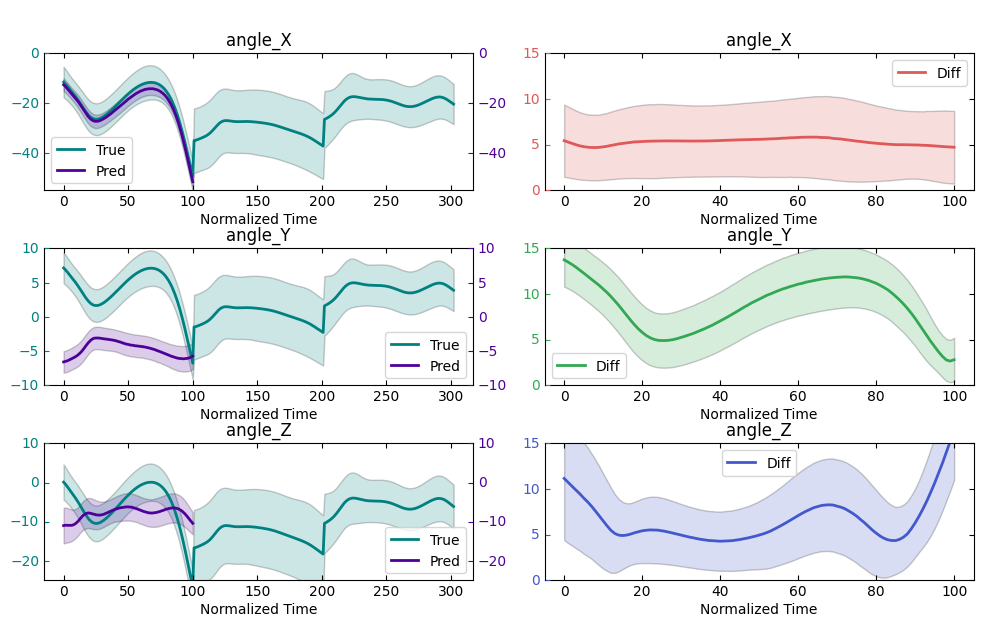

In [17]:
pp = PdfPages(join(targetDir,f"WHOLE_Total_result_{dataType}.pdf"))
# Plot actual predictions by axis all at once and errors below
plt.figure(figsize=(10, 6))
meanStdPlot(321,[true_X.mean(axis=0),true_X.std(axis=0),pred_X.mean(axis=0),pred_X.std(axis=0)],f"{dataType}_X")
diffPlot(322,[abs(true_X-pred_X).mean(axis=0),abs(true_X-pred_X).std(axis=0)],f"{dataType}_X")
meanStdPlot(323,[true_Y.mean(axis=0),true_Y.std(axis=0),pred_Y.mean(axis=0),pred_Y.std(axis=0)],f"{dataType}_Y")
diffPlot(324,[abs(true_Y-pred_Y).mean(axis=0),abs(true_Y-pred_Y).std(axis=0)],f"{dataType}_Y")
meanStdPlot(325,[true_Z.mean(axis=0),true_Z.std(axis=0),pred_Z.mean(axis=0),pred_Z.std(axis=0)],f"{dataType}_Z")
diffPlot(326,[abs(true_Z-pred_Z).mean(axis=0),abs(true_Z-pred_Z).std(axis=0)],f"{dataType}_Z")
plt.tight_layout()
pp.savefig()
pp.close()